In [2]:
""" This is portfolio optimizer, trying to find best perfoming portofio in terms of Sharp ratio."""
""" Minimizer examples"""

%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import scipy.optimize as spo
from math import sqrt

In [3]:
""" Functions to use later in the program """
def symbol_to_path(symbol, base_dir='data'):
    """Return CSV file path given ticker symbol"""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        # TODO: Read and join data for each symbol
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col = "Date", parse_dates = True, usecols = ['Date', 'Adj Close'], na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp, how = 'inner')
        df.dropna()
    df = df.sort_index()
    return df

def plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
def normalize_data(dataframe):
    """ Normalize stock prices using first row of the dataframe"""
    return dataframe / dataframe.ix[0,:]

def compute_daily_returns(df):
    """Compute and return the daily return values."""
    df = df.pct_change()
    df.ix[0] = 0
    return df

In [4]:
""" Load data for few stocks to choose from for the portfolio."""
# Define start and end dates.
start_date = '2010-01-01'
end_date = '2010-12-31'
dates = pd.date_range(start_date,end_date)

# Choose which stocks to use
symbols = ['GOOG', 'IBM', 'AAPL', 'XOM']

# Get stock data into DataFrame
df = get_data(symbols, dates)
df = df.drop('SPY',1)           # Don't need SPY in dataframe, so it's removed.
print df.head(5)

              GOOG     IBM    AAPL    XOM
2010-01-04  626.75  126.24  213.10  64.55
2010-01-05  623.99  124.71  213.46  64.80
2010-01-06  608.26  123.90  210.07  65.36
2010-01-07  594.10  123.47  209.68  65.15
2010-01-08  602.02  124.71  211.07  64.89


In [9]:
# Portfolio variables
start_cash = 1000000
allocations = np.array([0.1,0.2,0.4,0.3])

normalized_prices = normalize_data(df)
allocated = normalized_prices * allocations
position_vals = allocated * start_cash
portfolio_vals = position_vals.sum(axis=1)
portfolio_rets = compute_daily_returns(portfolio_vals)
portfolio_rets = portfolio_rets[1:]

print 'Cash after this allocations: {:.0f} $'.format(portfolio_vals[-1])
print 'Cumulative return: {:.2f}%'.format((portfolio_vals[-1] / start_cash - 1)*100)
print 'Sharp ratio for given portfolio: {:.3f}'.format(calculate_sharp_ratio(portfolio_rets))

Cash after this allocations: 1249275 $
Cumulative return: 24.93%
Sharp ratio for given portfolio: 0.028


In [10]:
# Create Sharp ratio calculator
def calculate_sharp_ratio(dataframe, risk_free=0.,sampling=252.):
    dataframe = compute_daily_returns(dataframe)
    std = dataframe.std()
    mean = dataframe.mean()
    return sqrt(sampling) * (mean - risk_free)/std

In [24]:
# Define error function for optimizer to minimize
def minimizeFunction(portfolio_allocs,data=df):
    normalized_prices = normalize_data(data)
    allocated = normalized_prices * portfolio_allocs
    portfolio_vals = allocated.sum(axis=1)
    
    portfolio_rets = compute_daily_returns(portfolio_vals)
    portfolio_rets = portfolio_rets[1:]
    sharpRatio = calculate_sharp_ratio(portfolio_rets)
    # print 'Sharp ratio: {:.2f}, sum:{:.3f}, allocs: {}'.format(sharpRatio,sum(abs(portfolio_allocs)),portfolio_allocs)
    return -sharpRatio

In [120]:
cons={
    'type': 'eq',
    'fun' : lambda x : sum(abs(x)) - 1.
}
bnds=(
    (0.,.5),
    (0.,.5),
    (0.,.5),
    (0.,.5)
)
np.random.seed()
x_guess = np.random.rand(4)
min_result = spo.minimize(minimizeFunction,x_guess, method='SLSQP',bounds=bnds, constraints=cons, options={'disp':True})
print 'Minima found at:'
print 'X = {}, sharp ratio = {}'.format(min_result.x,min_result.fun)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.00198508159
            Iterations: 19
            Function evaluations: 209
            Gradient evaluations: 19
Minima found at:
X = [ 0.00141614  0.4981004   0.47226829  0.02821517], sharp ratio = -1.00198508159


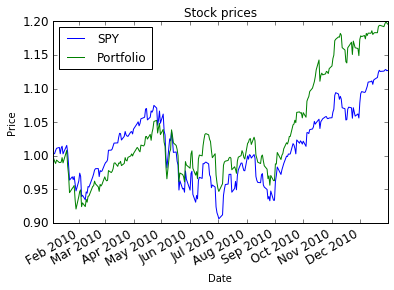

In [111]:
# Compare performance of the given portfolio in comparison to SPY
dfSPY = get_data([],dates)
dfSPY_norm = normalize_data(dfSPY)

allocations = min_result.x
normalized_prices = normalize_data(df)
allocated = normalized_prices * allocations
portfolio_vals = allocated.sum(axis=1)

portfolio_vals = pd.DataFrame(portfolio_vals,columns={'Portfolio'})

compare_portfolio = dfSPY_norm
compare_portfolio = compare_portfolio.join(portfolio_vals)
plot_data(compare_portfolio)